### Case Study 1

[Kaggle - dataset description](https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset)

In [467]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, roc_auc_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
import time
from imblearn.over_sampling import SMOTENC
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
import plotly.graph_objects as go

In [370]:
dane=pd.read_csv("../datasets/case1.csv", delimiter=";")
dane=dane.drop(columns=["Unnamed: 0", "Index", "Address"])
y_data=dane[["FLAG"]]
X_data=dane.drop(columns="FLAG")

In [371]:
y_data.value_counts()/y_data.value_counts().sum()

FLAG
0       0.778579
1       0.221421
Name: count, dtype: float64

### Podział na treningowe i testowe

In [372]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [373]:
X_train['ERC20 most sent token type'] = X_train['ERC20 most sent token type'].astype("category")
X_train['ERC20_most_rec_token_type'] = X_train['ERC20_most_rec_token_type'].astype("category")

In [374]:
X_train_num=X_train.iloc[:,:-2]
X_train_text=X_train.iloc[:, -2:]

X_test_num=X_test.iloc[:,:-2]
X_test_text=X_test.iloc[:, -2:]

#### Text processing

In [375]:
X_train_text.replace(["0", "", " ", np.nan], None, inplace=True)
X_test_text.replace(["0", "", " ", np.nan], None, inplace=True)

C:\Users\dorot\AppData\Local\Temp\ipykernel_25220\2368026040.py:1: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



In [376]:
X_train_text.iloc[:, -1].value_counts().to_csv("tokens_last.csv")
X_train_text.iloc[:, -2].value_counts().to_csv("tokens_2last.csv")

In [457]:
data_0 =X_train[y_train['FLAG']==0]['ERC20_most_rec_token_type']
data_1 = X_train[y_train['FLAG']==1]['ERC20_most_rec_token_type']

In [462]:
word_freq_0 = data_0.str.split(expand=True).stack().value_counts()/data_0.shape[0]

# Obliczenie odsetków wystąpień słów dla y=1
word_freq_1 = data_1.str.split(expand=True).stack().value_counts()/data_1.shape[0]

# Stworzenie ramki danych z wynikami
word_freq_df = pd.DataFrame({'y=0': word_freq_0, 'y=1': word_freq_1}).fillna(0)

# Sortowanie ramki danych po odsetkach wystąpień słów w y=0
word_freq_df = word_freq_df.sort_values(by='y=0', ascending=False)

# Wybór 20 najczęściej występujących słów
top_20_words = word_freq_df.head(20)

In [468]:
data=top_20_words.reset_index()
# Tworzenie obiektów Bar dla każdej serii danych
trace_y_0 = go.Bar(data, x=index, y=y_0, name='y=0', marker=dict(color='blue'))
trace_y_1 = go.Bar(data, x=index, y=y_1, name='y=1', marker=dict(color='red'))

# Tworzenie obiektu figury
fig = go.Figure([trace_y_0, trace_y_1])

# Ustawienia wykresu
fig.update_layout(
    title='Values for y=0 and y=1',
    xaxis=dict(title='Index'),
    yaxis=dict(title='Value')
)

# Wyświetlanie wykresu
fig.show()

NameError: name 'index' is not defined

ValueError: Could not interpret input 'value'

<Figure size 720x432 with 0 Axes>

In [377]:
id_notnull=(X_train_text.iloc[:, -2:].isna().sum(axis=1)==0).reset_index(drop=True)

#### Numeric data processing

In [378]:
X_cols=X_train_num.columns

scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(X_train_num)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=X_cols)

scaled_test_data = scaler.transform(X_test_num)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=X_cols)

In [379]:
scaled_train_df2=pd.concat([y_data, scaled_train_df], axis=1)

In [380]:
fig = px.box(scaled_train_df2, color="FLAG")
fig.update_layout(xaxis_title="Nr zmiennej",
                  yaxis_title="Wartość zestandaryzowana")
fig.write_html("boxplot_alldata.html")

In [381]:
combined_X_train_data = pd.concat([scaled_train_df, X_train_text.reset_index(drop=True)], axis=1)
combined_X_test_data = pd.concat([scaled_test_df, X_test_text.reset_index(drop=True)], axis=1)

combined_X_test_data['ERC20 most sent token type'] = combined_X_test_data['ERC20 most sent token type'].astype("category")
combined_X_test_data['ERC20_most_rec_token_type'] = combined_X_test_data['ERC20_most_rec_token_type'].astype("category")

In [382]:
y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

#### Resampling

In [383]:
y_train.value_counts()

FLAG
0       6120
1       1752
Name: count, dtype: int64

In [384]:
#Wiersze z niepustym tekstem
y_train[id_notnull].value_counts()

FLAG
0       1105
1        112
Name: count, dtype: int64

In [385]:
#Dodatkowe wiersze na podstawie pełnych wierszy
# sm = SMOTENC(random_state=42, categorical_features=[-1, -2], sampling_strategy=0.2)
# X_smote, y_smote = sm.fit_resample(combined_X_train_data[id_notnull], y_train[id_notnull])

In [386]:
#Nowy zestaw wierszy
y_smote.value_counts()

FLAG
0       1105
1        221
Name: count, dtype: int64

In [387]:
#Złączenie z wierszami z pustymi wartościami tekstowymi
# X_over=pd.concat([X_smote, combined_X_train_data[~id_notnull]], axis=0)
# y_over=pd.concat([y_smote, y_train[~id_notnull]], axis=0)

In [388]:
#UnderSampling
rus=RandomUnderSampler(sampling_strategy=0.4)
X_resampled, y_resampled =rus.fit_resample(combined_X_train_data, y_train)
print(y_resampled .value_counts())

FLAG
0       4380
1       1752
Name: count, dtype: int64


#### Testy dla różnych modeli

In [389]:
X_resampled['ERC20 most sent token type'] = X_resampled['ERC20 most sent token type'].astype("category")
X_resampled['ERC20_most_rec_token_type'] = X_resampled['ERC20_most_rec_token_type'].astype("category")

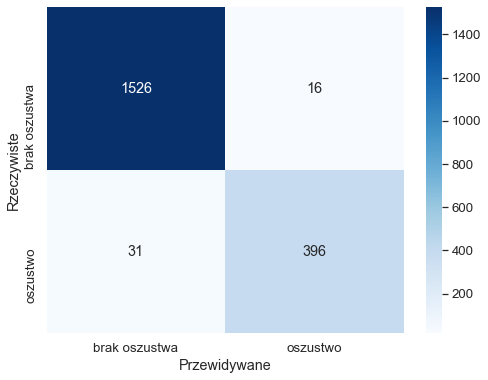

In [390]:
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
# X is the dataframe we created in previous snippet
clf.fit(X_resampled, y_resampled)

y_pred = clf.predict(combined_X_test_data)

cm = confusion_matrix(y_test, y_pred)
class_names = ['brak oszustwa', 'oszustwo']
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

class_rep=classification_report(y_test, y_pred)

In [391]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [392]:
X_train_num=X_train.iloc[:,:-2]
X_train_text=X_train.iloc[:, -2:]

X_test_num=X_test.iloc[:,:-2]
X_test_text=X_test.iloc[:, -2:]

In [393]:
X_train_text.replace(["0", "", " ", np.nan], None, inplace=True)
X_test_text.replace(["0", "", " ", np.nan], None, inplace=True)

In [394]:
X_cols=X_train_num.columns

scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(X_train_num)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=X_cols)

scaled_test_data = scaler.transform(X_test_num)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=X_cols)

In [395]:
X_test['ERC20 most sent token type'] = X_test['ERC20 most sent token type'].astype("category")
X_test['ERC20_most_rec_token_type'] = X_test['ERC20_most_rec_token_type'].astype("category")

In [396]:
clf.score(X_test, y_test)

0.8105637379380396

In [398]:
X_train['ERC20 most sent token type'] = X_train['ERC20 most sent token type'].astype("category")
X_train['ERC20_most_rec_token_type'] = X_train['ERC20_most_rec_token_type'].astype("category")

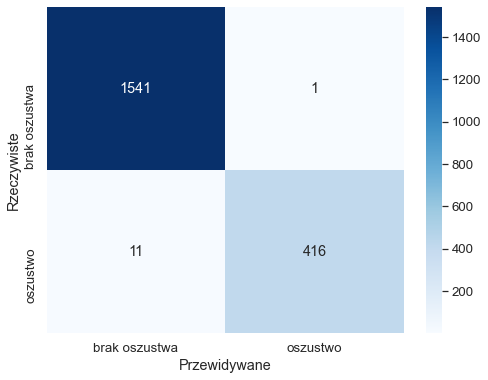

In [399]:
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
# X is the dataframe we created in previous snippet
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
class_names = ['brak oszustwa', 'oszustwo']
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

class_rep=classification_report(y_test, y_pred)

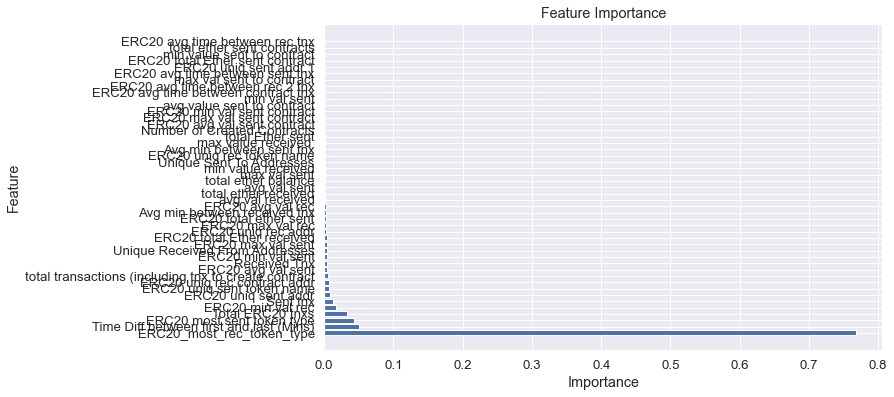

In [400]:
model=clf
importance = model.feature_importances_

# Pobranie nazw zmiennych
feature_names = X_train.columns

# Stworzenie DataFrame z ważnościami zmiennych
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Posortowanie wartości ważności malejąco
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Wykres ważności zmiennych
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
# models = {
#     'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=50),
#     'RandomForest': RandomForestClassifier(n_estimators=50, max_depth=40),
# }


# results = pd.DataFrame(columns=['Model', 'ROC-AUC', 'Czas wykonywania'])

# for model_name, model in models.items():

#         start=time.time()
#         cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#         scores = cross_val_score(model, X_resampled, y_resampled, scoring='roc_auc', cv=cv, n_jobs=-1)
#         czas=time.time()-start

#         result_row ={
#             'Model': model_name,
#             'ROC-AUC': np.mean(scores),
#             'Czas wykonywania': czas
#         }
#         print(result_row)

#         results=pd.concat([results, pd.DataFrame([result_row])], ignore_index=True)